## Set up

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/Learning/20202/NLP/data'
train_path = '/content/drive/MyDrive/Learning/20202/NLP/data/train.csv'
val_path = '/content/drive/MyDrive/Learning/20202/NLP/data/val.csv'
test_path = '/content/drive/MyDrive/Learning/20202/NLP/data/test.csv'

In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras import layers
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
import re
import keras

In [5]:
sent2idx = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}
topic2idx = {
    'lecturer': 0,
    'program': 1,
    'facility': 2,
    'other': 3
}

idx2sent = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

idx2topic = {
    0: 'lecturer',
    1: 'program',
    2: 'facility',
    3: 'other'
}

In [6]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          results_path='/content/drive'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(
        accuracy, misclass))
    
    if not os.path.exists(results_path):
        os.mkdir(results_path)
    if normalize:
        plt.savefig(results_path + f'/{title}_normalize.png')
    else:
        plt.savefig(results_path+ f'/{title}.png')
    plt.show()

In [7]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

train_df['y_sent'] = train_df['sentiment'].apply(lambda x: sent2idx[x])
train_df['y_topic'] = train_df['topic'].apply(lambda x: topic2idx[x])

val_df['y_sent'] = val_df['sentiment'].apply(lambda x: sent2idx[x])
val_df['y_topic'] = val_df['topic'].apply(lambda x: topic2idx[x])

test_df['y_sent'] = test_df['sentiment'].apply(lambda x: sent2idx[x])
test_df['y_topic'] = test_df['topic'].apply(lambda x: topic2idx[x])

In [8]:
from gensim.models import KeyedVectors

def get_w2v(fname, fvocab, word_index):
    kv_embed = KeyedVectors.load_word2vec_format(fname, fvocab)
    vector_size = kv_embed.vector_size
    matrix = np.random.uniform(0.0, 1.0, size=(len(word_index), vector_size))

    num_token_not_embed = 0
    for word, i in word_index.items():
        try:
            matrix[i] = kv_embed.get_vector(word)
        except:
          num_token_not_embed += 1
    print('Num of token not in pretrain word embedd: ', num_token_not_embed)
    return matrix

In [9]:
# configs
seq_len = 80

# data generator
tokenizer = Tokenizer(num_words=seq_len, lower=True, split=' ', oov_token=True)
tokenizer.fit_on_texts(train_df['text'].values)
word_index = tokenizer.word_index
fname = '/content/drive/MyDrive/Learning/20202/NLP/w2v/viki_w2v.txt'
fvocab = '/content/drive/MyDrive/Learning/20202/NLP/w2v/viki_w2v_vocab.txt'
word_vector = get_w2v(fname, fvocab, word_index)
print(word_vector.shape)

vocab_size = len(word_index)
embed_dim = 100
hidden_dim = 128

Num of token not in pretrain word embedd:  471
(2489, 100)


In [10]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

## Only Sentiment Classification

In [11]:
# Data generator
from tensorflow.keras.utils import Sequence, to_categorical
class SingleOutDataGenerator(Sequence):
    def __init__(
        self,
        data_df,
        tokenizer=None,
        batch_size=64,
        seq_len=80,
        n_sent=3,
        n_topic=4,
        shuffle=True,
        out_type='sentiment'
    ):
        self.texts = data_df['text'].tolist()
        self.sentiment_label = data_df['y_sent']
        self.topic_label = data_df['y_topic']
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.n_sent = n_sent
        self.n_topic = n_topic
        self.shuffle = shuffle
        self.num_samples = len(data_df)
        self.indexes = np.arange(self.num_samples)
        if tokenizer is None:
            tokenizer = Tokenizer(
              num_words=seq_len,
              split=' ',
              oov_token=True,
              lower=True
            )
            tokenizer.fit_on_texts(data_df['text'].values)
        self.tokenizer = tokenizer
        self.out_type = out_type

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(len(self.texts)/self.batch_size)

    def __data_generator(self, indexes):
        x = np.zeros((self.batch_size, self.seq_len))
        texts = [self.texts[i] for i in indexes]
        texts = self.tokenizer.texts_to_sequences(texts)
        sentiments = [self.sentiment_label[i] for i in indexes]
        topics = [self.topic_label[i] for i in indexes]
        x = pad_sequences(texts, maxlen=seq_len, padding='post', truncating='post')
        y_sent = to_categorical(sentiments, num_classes=self.n_sent, dtype='int32')
        y_topic = to_categorical(topics, num_classes=self.n_topic, dtype='int32')
        return x, y_sent, y_topic

    def __getitem__(self, index):
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
      x, y_sent, y_topic = self.__data_generator(indexes)
      if self.out_type == 'sentiment':
          return x, y_sent
      elif self.out_type == 'topic':
          return x, y_topic

In [12]:
def build_topic_model(seq_len, vocab_size, embed_dim, hidden_dim, word_vector=None):
    input = Input(shape=(seq_len,), name='input')
    if word_vector is not None:
        embed = Embedding(vocab_size, embed_dim, weights=[word_vector], name='embedding')(input)
    else:
        embed = Embedding(vocab_size, embed_dim, name='embedding')(input)
    hidden = Bidirectional(layers.LSTM(hidden_dim, return_sequences=True, dropout=0.4, recurrent_dropout=0.4), name='bi_lstm_layer1')(embed)
    hidden = Bidirectional(LSTM(hidden_dim, dropout=0.4, recurrent_dropout=0.4), name='bi_lstm_layer2')(hidden)
    hidden = layers.Dropout(0.3)(hidden)
    
    out = Dense(128, activation='relu', name='project')(hidden)
    out = layers.Dropout(0.3)(out)
    out = Dense(4, activation='softmax', name='topic_clf')(out)
    model = keras.Model(inputs=input, outputs=out)
    return model

In [13]:
# data generator
train_generator = SingleOutDataGenerator(train_df, tokenizer=tokenizer, batch_size=216, seq_len=seq_len, out_type='topic')
val_generator = SingleOutDataGenerator(val_df, tokenizer=tokenizer, batch_size=216, seq_len=seq_len, out_type='topic')
test_generator = SingleOutDataGenerator(test_df, tokenizer=tokenizer, batch_size=216, seq_len=seq_len, out_type='topic')

In [14]:
import os
vocab_size = len(tokenizer.word_index)

topic_clf  = build_topic_model(seq_len=seq_len, vocab_size=vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim, word_vector=word_vector)
print(topic_clf.summary())
# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=10)

# learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

model_dir = f'/content/drive/MyDrive/Learning/20202/NLP/models/{topic_clf.name}'

if os.path.exists(model_dir) is False:
    os.mkdir(model_dir)
# checkpoint
checkpoint_filepath = model_dir + '/topic_checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# load checkpoint
checkpoint = False
if checkpoint:
    topic_clf.load_weights(checkpoint_filepath)
    print(f'Load checkpoint from {checkpoint_filepath} done!') 

# compile model
topic_clf.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 100)           248900    
_________________________________________________________________
bi_lstm_layer1 (Bidirectiona (None, 80, 256)           234496    
_________________________________________________________________
bi_lstm_layer2 (Bidirectiona (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
project (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [15]:

# training
history_training = topic_clf.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=train_generator,
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, model_checkpoint_callback]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
52/52 [==============================] - 93s 2s/step - loss: 0.7592 - accuracy: 0.7172 - val_loss: 0.4773 - val_accuracy: 0.8009
Epoch 2/30
52/52 [==============================] - 80s 2s/step - loss: 0.4965 - accuracy: 0.8030 - val_loss: 0.4034 - val_accuracy: 0.8452
Epoch 3/30
52/52 [==============================] - 80s 2s/step - loss: 0.4669 - accuracy: 0.8131 - val_loss: 0.4183 - val_accuracy: 0.8399
Epoch 4/30
52/52 [==============================] - 79s 2s/step - loss: 0.4525 - accuracy: 0.8259 - val_loss: 0.3875 - val_accuracy: 0.8459
Epoch 5/30
52/52 [==============================] - 78s 2s/step - loss: 0.4212 - accuracy: 0.8331 - val_loss: 0.3725 - val_accuracy: 0.8472
Epoch 6/30
52/52 [==============================] - 79s 2s/step - loss: 0.4131 - accuracy: 0.8363 - val_loss: 0.3828 - val_accuracy: 0.8519
Epoch 7/30
52/52 [==============================] - 79s 2s/step - loss: 0.4040 - accuracy: 0.8424 - val_loss: 0.3664 - val_accuracy: 0.8664
Epoch 8/30
52/52 [==

In [16]:
print(topic_clf.metrics_names)

['loss', 'accuracy']


In [18]:
topic_clf.evaluate_generator(test_generator, steps=len(test_generator))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.48584163188934326, 0.8346560597419739]

[0.4927268326282501, 0.8594576716423035]

In [19]:
topic_clf.save('/content/drive/MyDrive/Learning/20202/NLP/models/topic_clf.h5')

### Evaluate


In [20]:
# process test dataset
X_test = tokenizer.texts_to_sequences(test_df['text'].values)
X_test = pad_sequences(X_test, maxlen=seq_len, padding='post', truncating='post')


In [21]:
from scipy.special import softmax

In [22]:
out = topic_clf.predict(X_test, batch_size=64)
print(out.shape)

(3166, 4)


In [23]:
out_soft = softmax(out, axis=1)
topic_pred = np.argmax(out_soft, axis=1)
topic_true = test_df['y_topic'].to_numpy()

print(topic_pred)
print(topic_true)

[0 0 0 ... 0 3 0]
[0 0 0 ... 0 0 1]


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc  = accuracy_score(topic_true, topic_pred)
precision = precision_score(topic_true, topic_pred, average='macro')
recall = recall_score(topic_true, topic_pred, average='macro')
f1 = f1_score(topic_true, topic_pred, average='macro')
print('Accuracy: ', acc)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1-score: ', f1)

Accuracy:  0.8335439039797852
Precision:  0.6541408190169566
Recall:  0.6735394711385768
F1-score:  0.6592505956894883



Accuracy:  0.8335439039797852

Precision:  0.6541408190169566

Recall:  0.6735394711385768

F1-score:  0.6592505956894883

In [26]:
topic_true_label = [idx2topic[x] for x in topic_true]
topic_pred_label = [idx2topic[x] for x in topic_pred]

results_path = '/content/drive/MyDrive/Learning/20202/NLP/results'
topics = list(topic2idx.keys())

test_df['topic_pred'] = topic_pred_label

test_predict_df = test_df.drop(columns=['y_sent', 'y_topic'])
test_predict_df.to_csv(results_path + '/prediction_topic.csv', index=False)

test_predict_df_false = test_predict_df[test_predict_df['topic_pred'] != test_predict_df['sentiment']]
test_predict_df_false.to_csv(results_path + '/false_topic.csv', index=False)

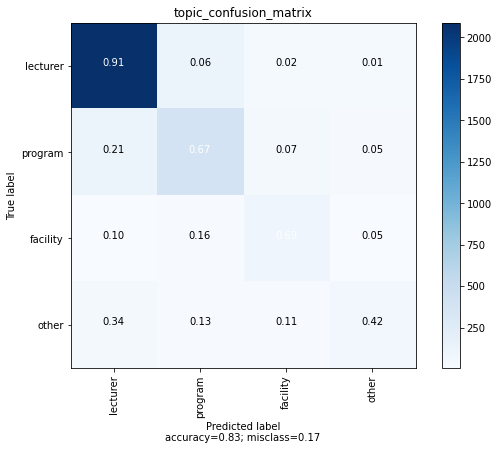

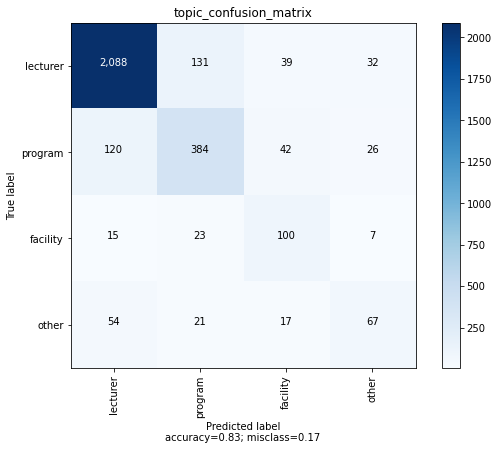

In [28]:
cm = confusion_matrix(topic_true_label, topic_pred_label, labels=topics)
plot_confusion_matrix(cm, topics ,title='topic_confusion_matrix', normalize=True, results_path=results_path)
plot_confusion_matrix(cm, topics, title='topic_confusion_matrix', normalize=False, results_path=results_path)

In [ ]:
# get predicts